In [1]:
import numpy as np

import tenpy
from tenpy.models.lattice import Square
from tenpy.models import CouplingMPOModel
from tenpy.networks.site import SpinHalfFermionSite, spin_half_species
from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg
from tenpy.algorithms.mps_common import DensityMatrixMixer
from timeit import default_timer as timer

/home1/wttai/TeNPy/tenpy/tools/optimization.py:317: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [2]:
class FermiHubbardSquare(CouplingMPOModel):
    
    def init_sites(self, model_params):
        cons_N = model_params.get('cons_N', 'N', str)
        cons_Sz = model_params.get('cons_Sz', 'Sz', str)
        site = SpinHalfFermionSite(cons_N=cons_N, cons_Sz=cons_Sz)
        return site

    def init_lattice(self, model_params):
        site = self.init_sites(model_params)
        Lx = model_params.get('Lx', 4)
        Ly = model_params.get('Ly', 4)
        bc_x = model_params.get('bc_x', 'open', str)
        bc_y = model_params.get('bc_y', 'open', str)
        return Square(Lx=Lx, Ly=Ly, site=site, bc = [bc_x, bc_y])

    def init_terms(self, model_params):
        # read out parameters
        t = model_params.get("t", 1.) 
        Uv = model_params.get("U", 1.)
        m = model_params.get("m", 1)
        bias = model_params.get("bias", 0)
        # add terms
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(Uv, u, 'NuNd')
            self.add_onsite(m, u, "Nu")
            self.add_onsite(-m, u, "Nd")
        for i1, i2, dx in self.lat.pairs["nearest_neighbors"]:
            print(i1, i2, dx)
            self.add_coupling(t, i1, "Cdu", i2, "Cu", dx, plus_hc=True)
            self.add_coupling(-t, i1, "Cdd", i2, "Cd", dx, plus_hc=True)
            if np.array_equal(dx, [1,0]):
                self.add_coupling(1j * t, i1, "Cdu", i2, "Cd", dx, plus_hc=True)
                self.add_coupling(1j * t, i1, "Cdd", i2, "Cu", dx, plus_hc=True)
            if np.array_equal(dx, [0,1]):
                self.add_coupling(t, i1, "Cdu", i2, "Cd", dx, plus_hc=True)
                self.add_coupling(-t, i1, "Cdd", i2, "Cu", dx, plus_hc=True)        
        # Add a bias term at the zeroth site to break degeneracy
        self.add_local_term(bias, [("Nd", [0,0,0])], 0)

In [6]:
L = 2
Lx = L
Ly = L
t = 1.0
U = 1.0
m = 5.0
pbc = True

# Create the Fermi-Hubbard Model
model_params = {
    't': t,                 # Nearest-neighbor hopping strength
    'U': U,                 # On-site Hubbard interaction
    'm': m,                 # Mass gap
    'Lx': Lx,
    'Ly': Ly,
    'cons_Sz': None,
    'cons_N': 'N',
    'bc_x': 'periodic' if pbc else 'open',
    'bc_y': 'periodic' if pbc else 'open',
    'bias': 1e-1
}

dmrg_params = {
    "mixer": DensityMatrixMixer,
    "mixer_params": {
        "amplitude": 0.3,
        "decay": 2,
        "disable_after": 50
    },
    "trunc_params": {
        "chi_max": 500, #bond dimension
        "svd_min": 1*10**-10
    },
    "max_E_err": 0.0001, #energy convergence step threshold
    "max_S_err": 0.0001, #entropy convergence step threshold
    "max_sweeps": 100  #may or may not be enough to converge
}


model = FermiHubbardSquare(model_params)
H_mpo = model.calc_H_MPO()
print(f'MPO bond dimensions: {H_mpo.chi}')

0 0 [1 0]
0 0 [0 1]
MPO bond dimensions: [2, 6, 10, 10, 2]


In [7]:
# Exact Diagonalization—for sanity check
#CAUTION: this does not fix the particle fillings
if Lx * Ly <= 8:
    test = tenpy.algorithms.exact_diag.ExactDiag(model)
    test.build_full_H_from_mpo()
    test.full_diagonalization()
    print(test.groundstate())

(-19.89999999999999, <npc.Array shape=(256,) labels=['ps']>)


In [11]:
product_state = ['empty' if n < Lx * Ly // 2 else 'up' for n in range(Lx * Ly)]
#product_state = ["up" for n in range(Lx * Ly)]

psi = MPS.from_product_state(model.lat.mps_sites(), product_state, bc=model.lat.bc_MPS, dtype=np.complex128)

engine = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)

E0, psi = engine.run()
print(f'Ground state energy: {E0}')

Ground state energy: -13.975386724690868


In [10]:
help(psi)

Help on MPS in module tenpy.networks.mps object:

class MPS(BaseMPSExpectationValue)
 |  MPS(sites, Bs, SVs, bc='finite', form='B', norm=1.0)
 |
 |  A Matrix Product State, finite (MPS) or infinite (iMPS).
 |
 |  Parameters
 |  ----------
 |  sites : list of :class:`~tenpy.networks.site.Site`
 |      Defines the local Hilbert space for each site.
 |  Bs : list of :class:`~tenpy.linalg.np_conserved.Array`
 |      The 'matrices' of the MPS. Labels are ``vL, vR, p`` (in any order).
 |  SVs : list of 1D array
 |      The singular values on *each* bond. Should always have length `L+1`.
 |      Entries out of :attr:`nontrivial_bonds` are ignored.
 |  bc : ``'finite' | 'segment' | 'infinite'``
 |      Boundary conditions as described in the table of the module doc-string.
 |  form : (list of) {``'B' | 'A' | 'C' | 'G' | 'Th' | None`` | tuple(float, float)}
 |      The form of the stored 'matrices', see table in module doc-string.
 |      A single choice holds for all of the entries.
 |
 |  Att

In [ ]:
pi

In [5]:
def index(i,j):
    return i * Ly + j

def compute_corr_sum(corrs, delta_x, delta_y, Lx, Ly):
    """
    Compute the correlation function between two operators separated by a distance delta_x, delta_y

    Parameters:
    corrs: list of correlation functions psi.correlation_function("Nu", "Nu")    
           corrs[i][j] is the correlation function between the i-th and j-th sites
    delta_x: distance in x direction
    delta_y: distance in y direction
    Lx: number of sites in x direction
    Ly: number of sites in y direction

    Return:
    result: sum of the correlation function over the lattice
    """
    # compute <n_is n_js>
    result = 0
    for i in range(Lx):
        for j in range(Ly):
            if i + delta_x >= Lx or j + delta_y >= Ly:
                continue
            result += corrs[index(i,j)][index(i+delta_x,j+delta_y)]
    return result

def compute_corr_results(corr_type, psi, Lx, Ly):
    """
    Compute the correlation results for a specific type of correlation function.

    Parameters:
    op1, op2: string representing the operator type
    psi: object containing the correlation function method
    Lx: number of sites in x direction
    Ly: number of sites in y direction

    Returns:
    corr_result: 2D numpy array of correlation sums
    """
    corrs = psi.correlation_function(*corr_type)
    corr_result = np.array([[compute_corr_sum(corrs, i, j, Lx, Ly) for j in range(Ly)] for i in range(Lx)])
    return corr_result

correlation_types = {
    "uu": ("Nu", "Nu"),
    "ud": ("Nu", "Nd"),
    "dd": ("Nd", "Nd")
}

# Compute and store correlation results
corrs_results = {}
for label, corr_type in correlation_types.items():
    corrs_results[label] = compute_corr_results(corr_type, psi, Lx, Ly)

NameError: name 'psi' is not defined

In [36]:
corrs_results

{'uu': array([[2.94824007e-31, 3.37729038e-65],
        [2.88004167e-63, 0.00000000e+00]]),
 'ud': array([[2.73777897e-32, 1.08136890e-32],
        [2.57051635e-32, 2.04137542e-32]]),
 'dd': array([[2.        , 0.43865534],
        [0.06134466, 0.41404012]])}

In [ ]:
psi.correlation_function("Nu", "Nu")

array([[1.04195412e-02, 4.76002132e-05, 4.76002132e-05, 9.49006612e-05],
       [4.76002132e-05, 1.04195412e-02, 9.49006612e-05, 4.76002132e-05],
       [4.76002132e-05, 9.49006612e-05, 1.04195412e-02, 4.76002132e-05],
       [9.49006612e-05, 4.76002132e-05, 4.76002132e-05, 1.04195412e-02]])

In [ ]:
engine.sweep_stats

{'sweep': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'N_updates': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60],
 'E': [-12.404987750429425,
  -12.406379029853337,
  -12.406379029853339,
  -12.406379029853337,
  -12.406379029853342,
  -12.406379029853339,
  -12.406379029853333,
  -12.40637902985333,
  -12.406379029853335,
  -12.406379029853339,
  -12.40637902985333,
  -12.406379029853332,
  -12.406379029853333,
  -12.406379029853337,
  -12.406379029853335],
 'Delta_E': [nan,
  -0.0013912794239114845,
  -1.7763568394002505e-15,
  1.7763568394002505e-15,
  -5.329070518200751e-15,
  3.552713678800501e-15,
  5.329070518200751e-15,
  3.552713678800501e-15,
  -5.329070518200751e-15,
  -3.552713678800501e-15,
  8.881784197001252e-15,
  -1.7763568394002505e-15,
  -1.7763568394002505e-15,
  -3.552713678800501e-15,
  1.7763568394002505e-15],
 'S': [0.8159429221629696,
  0.8607039754072904,
  0.8219409986735832,
  0.7921070493171921,
  0.771894939546697,
  0.75926497475187

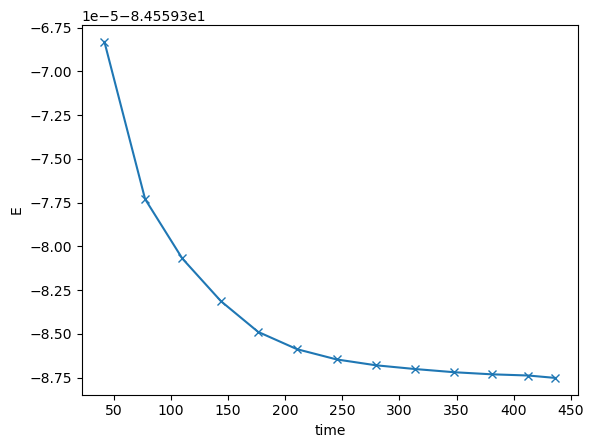

In [ ]:
engine.plot_sweep_stats()

In [ ]:
# Comparison with Martin's ed result

import sys, os
sys.path.append("common_lib/test/")
from test_qwz_spin_projected_energy import test_qwz_spin_projected_energy  
test_qwz_spin_projected_energy("square_8d0", t = t, m = m, U = U) 

Using square_8d0 with qwz
Evaluating the spectrum information for U = 1.0, t = 1.0, m = 1.0.
The low energy spectrum consists of energies: [-15.92535588 -15.14535794 -14.52283518 -14.52292879 -13.91636269]
